In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## Ranking

In [239]:
def read_csv(policy_name, dir, is_SB, case, file_or_folder):
    dataframes = []
    filenames = []

    for root, dirs, files in os.walk(dir):
        # Filter directories within the root directory
        dirs[:] = [d for d in dirs if d.startswith(policy_name) or policy_name == 'all']
        # Only proceed if we're in a directory that matches the folder prefix
        if (os.path.basename(root).startswith(policy_name)) or (policy_name == 'all'):
            # Loop through each file in the directory
            for file in files:
                # Check if file starts with the prefix
                all_boolean = (case == 'all') and any(file.startswith(word) for word in ['Base', 'Collab', 'Do_Nothing', 'FF_'])
                if file.startswith(case) or all_boolean:
                    file_path = os.path.join(root, file)
                    try:
                        # Load the file into a DataFrame
                        df = pd.read_csv(file_path)
                        # Store the DataFrame in the dictionary using the path as a key
                        dataframes.append(df)
                        filename = os.path.basename(root) if file_or_folder == 'folder' else file
                        filenames.append(filename)
                    except Exception as e:
                        print(f"Failed to read {file_path}: {e}")
    columns_sb = ['Bike Arrivals', 'Bike Starvations', 'Long Congestions']
    
    columns_ff = ['Escooter Arrivals', 'Escooter Starvations', 'Battery Starvations', 'Battery Violations'] #, 'Depot Visits', 'Number of battery swaps']
    columns_sol_time = ['Accumulated solution time', 'Number of get_best_action', 'Accumulated action time']
    
    fix_dfs = []
    for df in dataframes:
        if case.startswith('sol_time'):
            selected_columns = columns_sol_time 
        elif is_SB:
            selected_columns = columns_sb
        else:
            selected_columns = columns_ff
        fix_dfs.append(df[selected_columns])
    return fix_dfs, filenames

In [240]:
def make_pie(column_means):
    # Calculate the percentage contribution of each column's mean
    total_means = column_means.sum()
    percentage_means = (column_means / total_means) * 100

    # Plotting the pie chart
    plt.figure(figsize=(8, 8))  # Adjust the figure size as necessary
    plt.pie(percentage_means, labels=percentage_means.index, autopct='%1.1f%%', startangle=90)
    
    plt.show()

### Rank the results

In [241]:
dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/results_policies'
dataframes, filenames = read_csv('all', dir, False, 'all', 'folder')
filenames

['Collab2_res10_rad58',
 'Collab4_res10_rad58',
 'Base_res10_rad58',
 'FF_Only_Swap_res10_rad58',
 'FF_Only_Rebalance_res10_rad58',
 'Collab3_res10_rad58',
 'Do_Nothing_res10_rad58',
 'FF_Only_Rebalance2_res10_rad58']

In [242]:
means = []
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    filename = filenames[i]
    
    mean_series = dataframe.mean()
    mean_series['Filename'] = filename
    means.append(mean_series)

new_df = pd.DataFrame(means)
new_df['Sum'] = new_df.drop(columns=['Filename', 'Escooter Arrivals']).sum(axis=1)
new_df['Lost trips percentage'] = round(new_df['Sum'] / new_df[['Escooter Arrivals', 'Sum']].sum(axis=1) * 100, 2)
new_df['Rank failed events'] = new_df['Sum'].rank(method='min')
new_df['Rank p'] = new_df['Lost trips percentage'].rank(method='min')

new_column_order = ['Filename', 'Escooter Arrivals', 'Escooter Starvations', 'Battery Starvations', 'Battery Violations', 'Sum', 'Lost trips percentage', 'Rank failed events', 'Rank p'] #, 'Depot Visits', 'Number of battery swaps'] #, 'Vehicle Arrivals', 'Number of esooters delivered', 'Number of escooters picked up']
new_df = new_df[new_column_order]
new_df = new_df.sort_values('Filename')

new_df

,Filename,Escooter Arrivals,Escooter Starvations,Battery Starvations,Battery Violations,Sum,Lost trips percentage,Rank failed events,Rank p
2,Base_res10_rad58,27872.631579,11910.105263,998.789474,0.0,12908.894737,31.65,1.0,1.0
0,Collab2_res10_rad58,27773.947368,11906.105263,1026.315789,0.0,12932.421053,31.77,2.0,2.0
5,Collab3_res10_rad58,21157.894737,14899.157895,4620.315789,0.0,19519.473684,47.99,4.0,4.0
1,Collab4_res10_rad58,23032.263158,13961.684211,3702.842105,0.0,17664.526316,43.41,3.0,3.0
6,Do_Nothing_res10_rad58,12386.842105,17272.105263,11013.473684,0.0,28285.578947,69.54,8.0,8.0
7,FF_Only_Rebalance2_res10_rad58,12751.894737,17225.052632,10767.947368,0.0,27993.000000,68.70,7.0,7.0
4,FF_Only_Rebalance_res10_rad58,12885.000000,16915.526316,10847.315789,0.0,27762.842105,68.30,6.0,6.0
3,FF_Only_Swap_res10_rad58,15225.052632,16940.947368,8513.684211,0.0,25454.631579,62.57,5.0,5.0


### SB TABLE

In [117]:
dataframes2, filenames2 = read_csv('Collab4', dir, True, 'all', 'folder')

means2 = []
for i in range(len(dataframes2)):
    dataframe2 = dataframes2[i]
    filename2 = filenames2[i]
    
    mean_series2 = dataframe2.mean()
    mean_series2['Filename'] = filename2
    means2.append(mean_series2)

new_df2 = pd.DataFrame(means2)
new_df2['Sum'] = new_df2.drop(columns=['Filename', 'Bike Arrivals']).sum(axis=1)
new_df2['Lost trips percentage'] = round(new_df2['Sum'] / new_df2[['Bike Arrivals', 'Sum']].sum(axis=1) * 100, 2)
new_df2['Rank failed events'] = new_df2['Sum'].rank(method='min')
new_df2['Rank p'] = new_df2['Lost trips percentage'].rank(method='min')

new_column_order2 = ['Filename', 'Bike Arrivals', 'Bike Starvations', 'Long Congestions', 'Sum', 'Lost trips percentage', 'Rank failed events', 'Rank p']
new_df2 = new_df2[new_column_order2]
new_df2 = new_df2.sort_values('Filename')

new_df2

,Filename,Bike Arrivals,Bike Starvations,Long Congestions,Sum,Lost trips percentage,Rank failed events,Rank p
2,Collab4_res10_rad58_both,11744.842105,134.263158,490.631579,624.894737,5.05,1.0,1.0
0,Collab4_res10_rad58_dynamic,11877.631579,82.947368,703.263158,786.210526,6.21,2.0,2.0
1,Collab4_res10_rad58_static,11627.368421,251.315789,1169.947368,1421.263158,10.89,3.0,3.0


In [118]:
merged_df = pd.merge(new_df, new_df2, on='Filename', how='inner')
df = merged_df
df['Rank sum'] = df['Rank failed events_x'] +df['Rank failed events_y']
df

,Filename,Escooter Arrivals,Escooter Starvations,Battery Starvations,Battery Violations,Sum_x,Lost trips percentage_x,Rank failed events_x,Rank p_x,Bike Arrivals,Bike Starvations,Long Congestions,Sum_y,Lost trips percentage_y,Rank failed events_y,Rank p_y,Rank sum
0,Collab4_res10_rad58_both,23032.263158,13961.684211,3702.842105,0.0,17664.526316,43.41,1.0,1.0,11744.842105,134.263158,490.631579,624.894737,5.05,1.0,1.0,2.0
1,Collab4_res10_rad58_dynamic,18590.736842,15657.684211,6464.263158,0.0,22121.947368,54.34,2.0,2.0,11877.631579,82.947368,703.263158,786.210526,6.21,2.0,2.0,4.0
2,Collab4_res10_rad58_static,16146.526316,16369.000000,8248.684211,0.0,24617.684211,60.39,3.0,3.0,11627.368421,251.315789,1169.947368,1421.263158,10.89,3.0,3.0,6.0


In [119]:
df['Final Rank'] = df[['Rank p_x', 'Rank p_y']].max(axis=1)
df

,Filename,Escooter Arrivals,Escooter Starvations,Battery Starvations,Battery Violations,Sum_x,Lost trips percentage_x,Rank failed events_x,Rank p_x,Bike Arrivals,Bike Starvations,Long Congestions,Sum_y,Lost trips percentage_y,Rank failed events_y,Rank p_y,Rank sum,Final Rank
0,Collab4_res10_rad58_both,23032.263158,13961.684211,3702.842105,0.0,17664.526316,43.41,1.0,1.0,11744.842105,134.263158,490.631579,624.894737,5.05,1.0,1.0,2.0,1.0
1,Collab4_res10_rad58_dynamic,18590.736842,15657.684211,6464.263158,0.0,22121.947368,54.34,2.0,2.0,11877.631579,82.947368,703.263158,786.210526,6.21,2.0,2.0,4.0,2.0
2,Collab4_res10_rad58_static,16146.526316,16369.000000,8248.684211,0.0,24617.684211,60.39,3.0,3.0,11627.368421,251.315789,1169.947368,1421.263158,10.89,3.0,3.0,6.0,3.0


### Merge with solution time

In [96]:
dataframes2, filenames2 = read_csv('Base', dir, True, 'sol_time', 'folder')
filenames2

['Base_FF_res10_rad58_radius_3',
 'Base_FF_res10_rad58_radius_2',
 'Base_FF_res10_rad58_radius_0',
 'Base_FF_res10_rad58_radius_1']

In [99]:
import numpy as np

means2 = []
for i in range(len(dataframes2)):
    dataframe2 = dataframes2[i]
    filename2 = filenames2[i]
    
    mean_series2 = dataframe2.mean()
    mean_series2['Filename'] = filename2# [9:]
    means2.append(mean_series2)

new_df2 = pd.DataFrame(means2)

new_df2['avg_solution_time'] = new_df2['Accumulated solution time'].astype(float) / new_df2['Number of get_best_action'].replace(0, np.nan).astype(float)

new_df2['avg_action_time'] = new_df2['Accumulated action time'].astype(float) / new_df2['Number of get_best_action'].replace(0, np.nan).astype(float)

new_df2['Rank sol_time'] = new_df2['avg_solution_time'].rank(method='min')

new_column_order1 = ['Filename', 'Accumulated solution time', 'Number of get_best_action', 'avg_solution_time', 'avg_action_time', 'Rank sol_time']
new_df2 = new_df2[new_column_order1]
new_df2 = new_df2.sort_values('Filename')

new_df2

,Filename,Accumulated solution time,Number of get_best_action,avg_solution_time,avg_action_time,Rank sol_time
2,Base_FF_res10_rad58_radius_0,17530.179057,1245.578947,14.073920,12.276261,4.0
3,Base_FF_res10_rad58_radius_1,5488.051342,706.578947,7.767075,24.262793,3.0
1,Base_FF_res10_rad58_radius_2,2281.231063,441.210526,5.170391,41.497077,2.0
0,Base_FF_res10_rad58_radius_3,1467.025734,325.315789,4.509544,57.742275,1.0


In [100]:
merged_df = pd.merge(new_df, new_df2, on='Filename', how='inner')
df = merged_df
df

,Filename,Escooter Arrivals,Escooter Starvations,Battery Starvations,Battery Violations,Sum,Lost trips percentage,Rank failed events,Rank p,Accumulated solution time,Number of get_best_action,avg_solution_time,avg_action_time,Rank sol_time
0,Base_FF_res10_rad58_radius_0,29427.578947,10918.631579,348.684211,0.0,11267.315789,27.69,1.0,1.0,17530.179057,1245.578947,14.073920,12.276261,4.0
1,Base_FF_res10_rad58_radius_1,27739.210526,11820.263158,1075.789474,0.0,12896.052632,31.74,2.0,2.0,5488.051342,706.578947,7.767075,24.262793,3.0
2,Base_FF_res10_rad58_radius_2,25061.526316,13504.210526,2217.368421,0.0,15721.578947,38.55,3.0,3.0,2281.231063,441.210526,5.170391,41.497077,2.0
3,Base_FF_res10_rad58_radius_3,23244.842105,14191.473684,3319.315789,0.0,17510.789474,42.97,4.0,4.0,1467.025734,325.315789,4.509544,57.742275,1.0


### Branching

In [211]:
list_filename = df['Filename'].str.split('_')
df['a'] = list_filename.str[2]
df['b'] = list_filename.str[4]
df

,Filename,Escooter Arrivals,Escooter Starvations,Battery Starvations,Battery Violations,Sum,Lost trips percentage,Rank failed events,Rank p,Accumulated solution time,Number of get_best_action,avg_solution_time,avg_action_time,Rank sol_time,a,b
0,branching_a_10_b_1_Base_FF.csv,26817.736842,12512.631579,1332.105263,0.0,13844.736842,34.05,54.0,54.0,1538.481036,716.684211,2.146665,24.158258,1.0,10,1
1,branching_a_10_b_2_Base_FF.csv,27248.421053,12257.894737,1187.263158,0.0,13445.157895,33.04,44.0,44.0,2204.510841,713.578947,3.089372,24.194793,15.0,10,2
2,branching_a_10_b_3_Base_FF.csv,27443.842105,12067.684211,1130.526316,0.0,13198.210526,32.47,35.0,35.0,2805.240897,706.000000,3.973429,24.293127,24.0,10,3
3,branching_a_10_b_4_Base_FF.csv,27719.000000,11803.894737,1111.842105,0.0,12915.736842,31.78,21.0,21.0,3473.564663,712.263158,4.876800,23.979088,29.0,10,4
4,branching_a_10_b_5_Base_FF.csv,27692.842105,11857.157895,1089.842105,0.0,12947.000000,31.86,24.0,25.0,4096.330041,706.842105,5.795255,24.143559,38.0,10,5
5,branching_a_1_b_10_Base_FF.csv,28149.157895,11577.000000,943.210526,0.0,12520.210526,30.79,2.0,2.0,7101.196168,718.894737,9.877936,23.638480,45.0,1,10
6,branching_a_1_b_15_Base_FF.csv,28347.263158,11421.263158,917.947368,0.0,12339.210526,30.33,1.0,1.0,9206.545075,707.947368,13.004561,24.207494,46.0,1,15
7,branching_a_1_b_1_Base_FF.csv,26864.894737,12392.526316,1400.684211,0.0,13793.210526,33.92,53.0,53.0,1545.436159,719.684211,2.147381,24.048779,2.0,1,1
8,branching_a_1_b_20_Base_FF.csv,28096.578947,11583.842105,964.210526,0.0,12548.052632,30.87,3.0,3.0,11679.250143,714.684211,16.341833,23.940275,47.0,1,20
9,branching_a_1_b_2_Base_FF.csv,27328.947368,12142.052632,1193.052632,0.0,13335.105263,32.79,41.0,41.0,2174.203170,715.526316,3.038607,24.020964,14.0,1,2


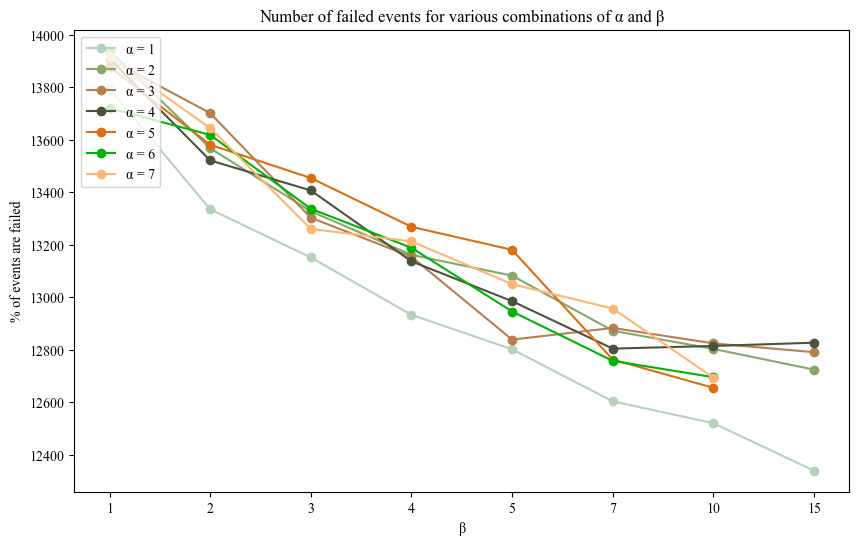

In [215]:
import matplotlib.ticker as ticker

# Assuming 'df' is your DataFrame
# Pivot your DataFrame as needed (if it is not already in the right format)
# Define the specific order of 'b' values you want to display on the x-axis
b_order = ['1', '2', '3', '4', '5', '7', '10', '15', '20']  # Adjust this list as needed

# Filter and convert 'b' to int for comparison, then set it as the DataFrame index
df1 = df[df['b'].astype(int).isin([int(x) for x in b_order])]
df1['b'] = pd.Categorical(df1['b'], categories=b_order, ordered=True)
df1.sort_values('b', inplace=True)
df1 = df1[df1['a'].astype(int) < 10]
df1 = df1[df1['b'].astype(int) < 20]
pivoted_df = df1.pivot(index='b', columns='a', values='Sum')

colors = ['#B4D3BA', '#86A86B', '#B57F50', '#4B543B', '#DB6F10', '#00B307', '#FFB674', '#000000']

# Start plotting
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed

# Plot each column

for i, column in enumerate(pivoted_df.columns):
    color = colors[i % len(colors)]  # Cycle through the color list
    ax.plot(pivoted_df.index, pivoted_df[column], marker='o', color=color, label=f'α = {column}')

# Customize the plot to match the uploaded image
ax.set_title('Number of failed events for various combinations of α and β')
ax.set_xlabel('β')
ax.set_ylabel('% of events are failed')
ax.legend(loc='upper left')

# It looks like the original plot uses a specific tick locator for the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

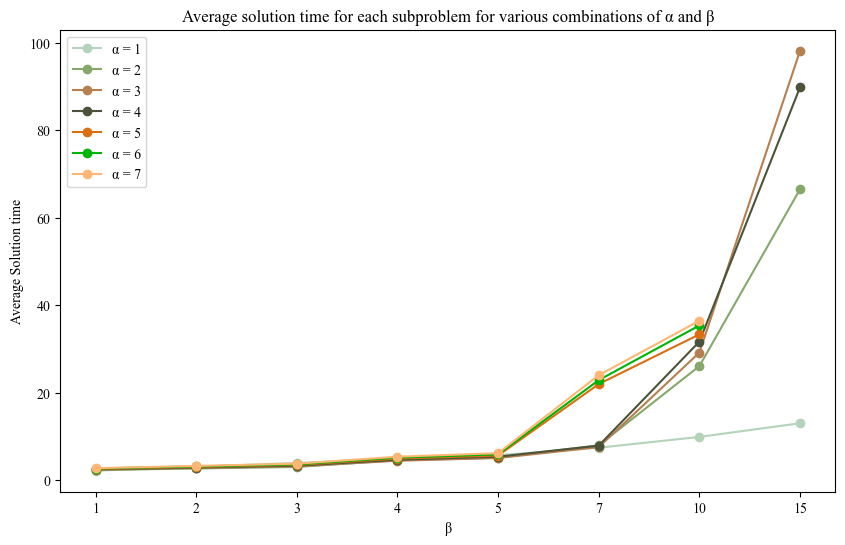

In [216]:
import matplotlib.ticker as ticker

# Assuming 'df' is your DataFrame
# Pivot your DataFrame as needed (if it is not already in the right format)
# Define the specific order of 'b' values you want to display on the x-axis
b_order = ['1', '2', '3', '4', '5', '7', '10', '15', '20']  # Adjust this list as needed

# Filter and convert 'b' to int for comparison, then set it as the DataFrame index
df1 = df[df['b'].astype(int).isin([int(x) for x in b_order])]
df1['b'] = pd.Categorical(df1['b'], categories=b_order, ordered=True)
df1.sort_values('b', inplace=True)
df1 = df1[df1['a'].astype(int) < 10]
df1 = df1[df1['b'].astype(int) < 20]
pivoted_df = df1.pivot(index='b', columns='a', values='avg_solution_time')

colors = ['#B4D3BA', '#86A86B', '#B57F50', '#4B543B', '#DB6F10', '#00B307', '#FFB674']

# Start plotting
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed

# Plot each column

for i, column in enumerate(pivoted_df.columns):
    color = colors[i % len(colors)]  # Cycle through the color list
    ax.plot(pivoted_df.index, pivoted_df[column], marker='o', color=color, label=f'α = {column}')

# Customize the plot to match the uploaded image
ax.set_title('Average solution time for each subproblem for various combinations of α and β')
ax.set_xlabel('β')
ax.set_ylabel('Average Solution time')
ax.legend(loc='upper left')

# It looks like the original plot uses a specific tick locator for the x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

## Cumulative trend

In [209]:
import os
import pandas as pd
def read_cumulated(policy_name, dir, case, file_or_folder):
    dfs = {}

    for root, dirs, files in os.walk(dir):
        # Filter directories within the root directory
        dirs[:] = [d for d in dirs if d.startswith(policy_name) or policy_name == 'all']
        # Only proceed if we're in a directory that matches the folder prefix
        if os.path.basename(root).startswith(policy_name) or policy_name == 'all':
            # Loop through each file in the directory
            for file in files:
                # Check if file starts with the prefix
                all_boolean = (case == 'all') and any(file.startswith(word) for word in ['Base', 'Collab', 'DoNothing', 'FF_'])
                if (file.startswith(case) or all_boolean) and file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    try:
                        # Load the file into a DataFrame
                        df = pd.read_csv(file_path, header=0, names=['Timestamp', 'Numbers'])
                        # Store the DataFrame in the dictionary using the path as a key
                        filename = os.path.basename(root) if file_or_folder == 'folder' else file
                        filename = case + '__' + os.path.basename(root) + '.csv' if file_or_folder == 'both' else filename
                        dfs[filename] = df
                    except Exception as e:
                        print(f"Failed to read {file_path}: {e}")
    return dfs

In [231]:
# folder = 'results_thresholds'
# folder = 'results_operator_radius_final'
# folder = 'inventory_balance'
# folder = 'results_num_vehicles'
# folder = 'results_policies'
folder = 'accumulated_policies'
# folders = ['results_thresholds', 'results_operator_radius_final', 'inventory_balance', 'results_num_vehicles']

# case = 'cumulated_battery starvations'
# case = 'cumulated_escooter starvations'
# case = 'cumulated_bike starvations'
# case = 'cumulated_long congestions'
case = 'all'
# cases = ['cumulated_battery']
# cases = ['cumulated_battery starvations', 
#          'cumulated_escooter starvations', 
#          'cumulated_bike starvations', 
#          'cumulated_long congestions']

# policy = 'all'
# policy = 'Base'
# policy = 'Base_FF'
# policy = 'Collab2'
# policy = 'Collab3'
# policy = 'Collab4'
policy = 'ess_'
# policies = ['FF_Only_Rebalance2'] #, 'Collab2', 'Collab3', 'Collab4']

### Calculate and write average csv

In [165]:
def latest_values_before_timestamp(df, unique_timestamps):
    results = []
    groups = df['Group'].unique()
    
    for timestamp in unique_timestamps:
        latest_values = []
        for group in groups:
            group_data = df[df['Group'] == group]
            filtered_data = group_data[group_data['Timestamp'] < timestamp]
            if not filtered_data.empty:
                latest_value = filtered_data.iloc[-1]['Numbers']
                latest_values.append(latest_value)
            else:
                latest_values.append(0)  # Use 0 if no value before the timestamp
        average_value = sum(latest_values) / len(latest_values)
        results.append((timestamp, average_value))
    
    return results

In [166]:
for policy in policies:
    for case in cases:
        dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/' + folder
        dataframes = read_cumulated(policy, dir, case, 'both')

        for filename, df in dataframes.items():
            df['Group'] = (df['Timestamp'] < df['Timestamp'].shift()).cumsum()

        dataframes_avg = {}
        for filename, df in dataframes.items():
            # Get all unique timestamps in ascending order
            unique_timestamps = sorted(df['Timestamp'].unique())

            # Calculate the average latest values before each timestamp
            averages = latest_values_before_timestamp(df, unique_timestamps)

            # Convert the results list to a DataFrame for better visualization
            averages_df = pd.DataFrame(averages, columns=['Timestamp', 'Average Value'])
            dataframes_avg[filename] = averages_df

        for filename, df in dataframes_avg.items():
            df.to_csv(f'{dir}/{filename}', sep=',', header=False, encoding='utf-8')
            print(filename, 'is done')

cumulated_battery starvations__FF_Only_Rebalance2_res10_rad58.csv is done
cumulated_escooter starvations__FF_Only_Rebalance2_res10_rad58.csv is done
cumulated_bike starvations__FF_Only_Rebalance2_res10_rad58.csv is done
cumulated_long congestions__FF_Only_Rebalance2_res10_rad58.csv is done


### One seed

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/' + folder
dataframes = read_cumulated(policy, dir, case, 'file')
list(dataframes.keys())

['FF_Only_Rebalance.csv',
 'Base.csv',
 'FF_Only_Rebalance2_new.csv',
 'Collab3.csv',
 'FF_Only_Swap.csv',
 'Collab2.csv',
 'Collab4.csv']

In [226]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/accumulated_policies/average_cumulated_failed/Do_Nothing.csv', header=0, names=['Timestamp', 'Numbers'])
# Convert 'Timestamp' to datetime if not already
# Ensure all timestamps include microseconds
df['Timestamp'] = df['Timestamp'].apply(lambda x: x if '.' in x else x + '.000000')

# Convert the 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Add a zero microseconds component
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
# Save the DataFrame back to a CSV file
df.to_csv('/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/accumulated_policies/average_cumulated_failed/Do_Nothing_new.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/accumulated_policies/average_cumulated_failed/Do_Nothing.csv'

In [234]:
dataframes_now = {}
for filename, df in dataframes.items():
    # Finding the first occurrence where the timestamp decreases
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    diffs = np.diff(df['Timestamp'].values)
    first_negative_index = np.where(diffs < np.timedelta64(0, 's'))[0]

    # Removing all rows after the first decrease in timestamp
    if first_negative_index.size > 0:
        df = df.iloc[:first_negative_index[0] + 1]
    dataframes_now[filename] = df

# Assuming dataframes_avg is a dictionary of DataFrames
common_index = pd.date_range(
    start=min(df['Timestamp'].min() for df in dataframes_now.values()), 
    end=max(df['Timestamp'].max() for df in dataframes_now.values()), 
    freq='T'  # or 'S' for second-level precision, 'H' for hour, etc.
)

# Reindex each DataFrame to the common index and interpolate missing values
for filename, df in dataframes_now.items():
    # df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # df.set_index('Timestamp', inplace=True)
    # df = df.reindex(common_index)
    # df['Numbers'] = df['Numbers'].interpolate()
    # dataframes_now[filename] = df
    # Ensure Timestamp is parsed correctly and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    
    # Remove duplicates in the DataFrame index
    df = df[~df.index.duplicated(keep='first')]
    
    # Ensure common_index is unique and in datetime format
    common_index = pd.to_datetime(common_index).drop_duplicates()
    
    # Reindex the DataFrame
    df = df.reindex(common_index)
    
    # Interpolate missing data values
    df['Numbers'] = df['Numbers'].interpolate()
    
    # Store the processed DataFrame
    dataframes_now[filename] = df

In [235]:
list(dataframes_now.keys())

['FF_Only_Rebalance.csv',
 'Base.csv',
 'FF_Only_Rebalance2_new.csv',
 'Collab3.csv',
 'FF_Only_Swap.csv',
 'Collab2.csv',
 'Collab4.csv']

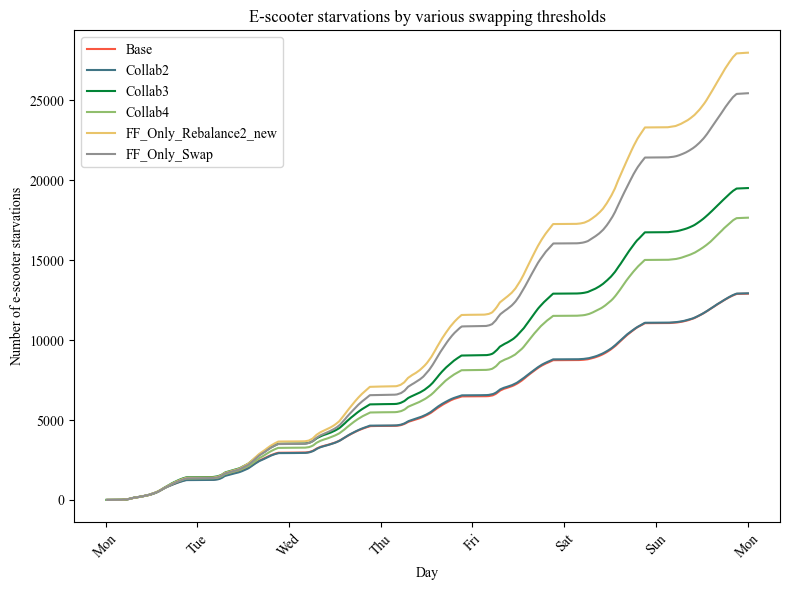

In [238]:
fig, ax = plt.subplots(figsize=(8, 6))

# Define desired order
# desired_order = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
desired_order = ['Base', 'Collab2', 'Collab3', 'Collab4', 'Nothing', 'FF_Only_Rebalance2_new', 'FF_Only_Swap']
# desired_order = ['static', 'dynamic', 'both', 'DoNothing']
colors = [
        '#F95741', 
        '#407585', 
        '#028436', 
        # '#7D5139',  
        # '#F95741', 
        '#90BE6D', '#F4A261', '#E9C46A', '#909090', '#264653']

# Plot each DataFrame in the desired order
for ind, order in enumerate(desired_order):
    for filename, df in dataframes_now.items():
        name = filename.split('.')[0]
        if order == name:
            plt.plot(df.index, df['Numbers'], label=name, color=colors[ind])

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.xlabel('Day')
plt.ylabel('Number of e-scooter starvations')
plt.title('E-scooter starvations by various swapping thresholds')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Calculate cumulative total failed events

In [167]:
# folder = 'results_thresholds'
# folder = 'results_operator_radius_final'
# folder = 'inventory_balance'
# folder = 'results_num_vehicles'
folder = 'accumulated_policies'
# folders = ['results_thresholds', 'results_operator_radius_final', 'inventory_balance', 'results_num_vehicles']

# case = 'cumulated_battery starvations'
cases = ['cumulated_escooter starvations', 'cumulated_battery starvations']

# case = 'cumulated_bike starvations'
# case = 'cumulated_long congestions'

# cases = ['cumulated_bike starvations', 
#          'cumulated_long congestions']

policy = 'average_cumulated_FF_Only_Rebalance2'
# policy = 'DoNothing'
# policy = 'Base'
# policy = 'Base_FF'
# policy = 'Collab2'
# policy = 'Collab3'
# policy = 'Collab4'
# policy = 'average_cumulated_Do_Nothing'
# policies = ['Base', 'Collab2', 'Collab3', 'Collab4']

In [168]:
import os
import pandas as pd
def read_cumulated_failed(policy_name, dir, case, file_or_folder):
    dfs = {}

    for root, dirs, files in os.walk(dir):
        # Filter directories within the root directory
        dirs[:] = [d for d in dirs if d.startswith(policy_name) or policy_name == 'all']
        # Only proceed if we're in a directory that matches the folder prefix
        if os.path.basename(root).startswith(policy_name) or policy_name == 'all':
            # Loop through each file in the directory
            for file in files:
                # Check if file starts with the prefix
                all_boolean = (case == 'all') and any(file.startswith(word) for word in ['Base', 'Collab', 'Do_Nothing', 'FF_'])
                if (any(file.startswith(case) for case in cases) or all_boolean) and file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    try:
                        # Load the file into a DataFrame
                        df = pd.read_csv(file_path, header=0, names=['Timestamp', 'Numbers'])
                        # Store the DataFrame in the dictionary using the path as a key
                        filename = os.path.basename(root) if file_or_folder == 'folder' else file
                        dfs[filename] = df
                    except Exception as e:
                        print(f"Failed to read {file_path}: {e}")
    return dfs

In [169]:
def latest_values_before_timestamp_total(df, unique_timestamps):
    results = []
    groups = df['Group'].unique()
    
    for timestamp in unique_timestamps:
        latest_values = []
        for group in groups:
            group_data = df[df['Group'] == group]
            filtered_data = group_data[group_data['Timestamp'] < timestamp]
            if not filtered_data.empty:
                latest_value = filtered_data.iloc[-1]['Numbers']
                latest_values.append(latest_value)
            else:
                latest_values.append(0)  # Use 0 if no value before the timestamp
        failed_events = sum(latest_values)
        results.append((timestamp, failed_events))
    
    return results

In [170]:
dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/' + folder
dataframes = read_cumulated_failed(policy, dir, case, 'file')
list(dataframes.keys())

['cumulated_battery starvations__FF_Only_Rebalance2.csv',
 'cumulated_escooter starvations__FF_Only_Rebalance2.csv']

In [171]:
merged_dfs = {}
for filename, df in dataframes.items():
    name = '_'.join(filename.split('_')[2:])
    if name not in list(merged_dfs.keys()):
        merged_dfs[name] = df
    else:
        # print(len(merged_dfs[name]), len(df))     
        merged_dfs[name] = pd.concat([merged_dfs[name], df], ignore_index=True)
        # print('-', len(merged_dfs[name]))

In [172]:
for filename, df in merged_dfs.items():
    df['Group'] = (df['Timestamp'] < df['Timestamp'].shift()).cumsum()

dataframes_total = {}
for filename, df in merged_dfs.items():
    # Get all unique timestamps in ascending order
    unique_timestamps = sorted(df['Timestamp'].unique())

    # Calculate the average latest values before each timestamp
    total = latest_values_before_timestamp_total(df, unique_timestamps)

    # Convert the results list to a DataFrame for better visualization
    totals_df = pd.DataFrame(total, columns=['Timestamp', 'Numbers'])
    dataframes_total[filename] = totals_df


In [173]:
for filename, df in dataframes_total.items():
    df.to_csv(f'{dir}/accumulated_total_{policy}.csv', sep=',', header=False, encoding='utf-8')
    print(filename, 'is done')

_FF_Only_Rebalance2.csv is done


### Plotting of FF-policies

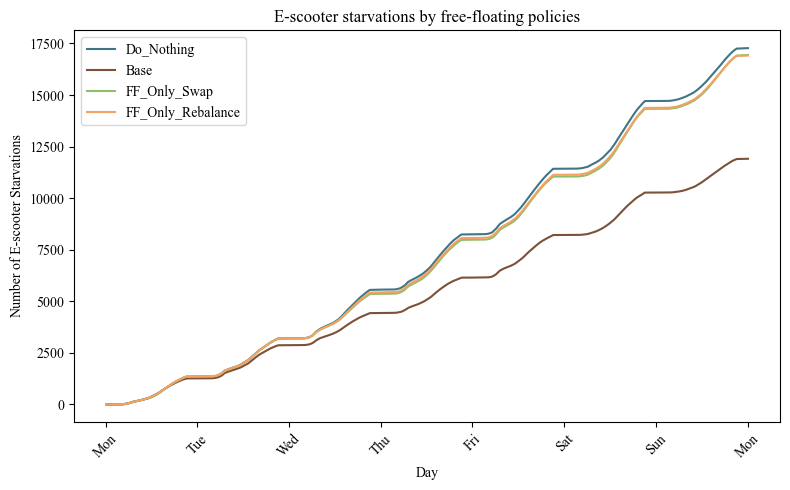

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def read_cumulated(policy_name, dir, case, file_or_folder):
    dfs = {}

    for root, dirs, files in os.walk(dir):
        # Filter directories within the root directory
        dirs[:] = [d for d in dirs if d.startswith(policy_name) or policy_name == 'all']
        # Only proceed if we're in a directory that matches the folder prefix
        if os.path.basename(root).startswith(policy_name) or policy_name == 'all':
            # Loop through each file in the directory
            for file in files:
                # Check if file starts with the prefix
                all_boolean = (case == 'all') and any(file.startswith(word) for word in ['Base', 'Collab', 'Do_Nothing', 'FF_'])
                if (file.startswith(case) or all_boolean) and file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    try:
                        # Load the file into a DataFrame
                        df = pd.read_csv(file_path, header=0, names=['Timestamp', 'Numbers'])
                        # Store the DataFrame in the dictionary using the path as a key
                        filename = os.path.basename(root) if file_or_folder == 'folder' else file
                        dfs[filename] = df
                    except Exception as e:
                        print(f"Failed to read {file_path}: {e}")
    return dfs

dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/results_policies'
dataframes = read_cumulated('average_cumulated', dir, 'cumulated_escooter', 'file')
list(dataframes.keys())

fig, ax = plt.subplots(figsize=(8, 5))

dataframes_now = {}
for filename, df in dataframes.items():
    # Finding the first occurrence where the timestamp decreases
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    diffs = np.diff(df['Timestamp'].values)
    first_negative_index = np.where(diffs < np.timedelta64(0, 's'))[0]

    # Removing all rows after the first decrease in timestamp
    if first_negative_index.size > 0:
        df = df.iloc[:first_negative_index[0] + 1]
    dataframes_now[filename] = df

# Assuming dataframes_avg is a dictionary of DataFrames
common_index = pd.date_range(
    start=min(df['Timestamp'].min() for df in dataframes_now.values()), 
    end=max(df['Timestamp'].max() for df in dataframes_now.values()), 
    freq='T'  # or 'S' for second-level precision, 'H' for hour, etc.
)

# Reindex each DataFrame to the common index and interpolate missing values
for filename, df in dataframes_now.items():
    df = df.copy()  # To avoid SettingWithCopyWarning
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    
    # Remove duplicate indices by taking the mean of the duplicates
    df = df.groupby(df.index).mean()
    
    df = df.reindex(common_index)
    df['Numbers'] = df['Numbers'].interpolate()
    dataframes_now[filename] = df

# Define desired order
desired_order = ['Do_Nothing', 'Base', 
                 'FF_Only_Swap', 'FF_Only_Rebalance', 
                #  'Collab2', 'Collab3', 'Collab4'
                 ]
colors = [
        #   '#2A9D8F', 
          '#407585', 
        #   '#028436', 
          '#7D5139',  
        #   '#F95741', 
          '#90BE6D', 
          '#F4A261', 
          '#E9C46A', 
          '#909090', 
          '#264653', 
          '#000000']

# Plot each DataFrame in the desired order
for ind, order in enumerate(desired_order):
    for filename, df in dataframes_now.items():
        name = '_'.join(filename.split('.')[0].split('_')[2:])
        if order == name:
            plt.plot(df.index, df['Numbers'], label=name, color=colors[ind])

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.xlabel('Day')
plt.ylabel('Number of E-scooter Starvations')
plt.title('E-scooter starvations by free-floating policies')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Plotting of swap threshold

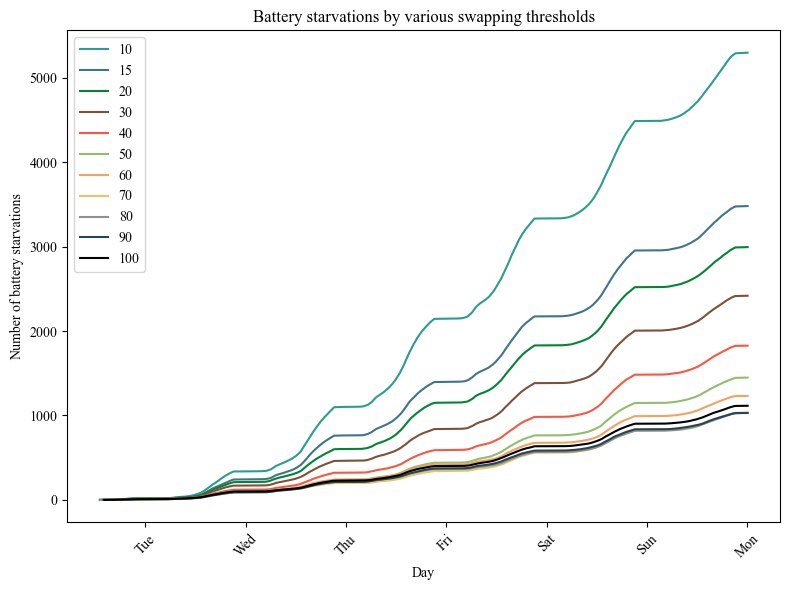

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def read_cumulated(policy_name, dir, case, file_or_folder):
    dfs = {}

    for root, dirs, files in os.walk(dir):
        # Filter directories within the root directory
        dirs[:] = [d for d in dirs if d.startswith(policy_name) or policy_name == 'all']
        # Only proceed if we're in a directory that matches the folder prefix
        if os.path.basename(root).startswith(policy_name) or policy_name == 'all':
            # Loop through each file in the directory
            for file in files:
                # Check if file starts with the prefix
                all_boolean = (case == 'all') and any(file.startswith(word) for word in ['Base', 'Collab', 'DoNothing', 'FF_'])
                if (file.startswith(case) or all_boolean) and file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    try:
                        # Load the file into a DataFrame
                        df = pd.read_csv(file_path, header=0, names=['Timestamp', 'Numbers'])
                        # Store the DataFrame in the dictionary using the path as a key
                        filename = os.path.basename(root) if file_or_folder == 'folder' else file
                        dfs[filename] = df
                    except Exception as e:
                        print(f"Failed to read {file_path}: {e}")
    return dfs

dir = '/Users/isabellam/NTNU/H2023/Prosjektoppgave/fomo/policies/hlv_master/results/results_new_threshold'
dataframes = read_cumulated('average_cumulated', dir, 'cumulated_battery starvations', 'file')

fig, ax = plt.subplots(figsize=(8, 6))

dataframes_now = {}
for filename, df in dataframes.items():
    # Finding the first occurrence where the timestamp decreases
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    diffs = np.diff(df['Timestamp'].values)
    first_negative_index = np.where(diffs < np.timedelta64(0, 's'))[0]

    # Removing all rows after the first decrease in timestamp
    if first_negative_index.size > 0:
        df = df.iloc[:first_negative_index[0] + 1]
    dataframes_now[filename] = df

# Assuming dataframes_avg is a dictionary of DataFrames
common_index = pd.date_range(
    start=min(df['Timestamp'].min() for df in dataframes_now.values()), 
    end=max(df['Timestamp'].max() for df in dataframes_now.values()), 
    freq='T'  # or 'S' for second-level precision, 'H' for hour, etc.
)

# Reindex each DataFrame to the common index and interpolate missing values
for filename, df in dataframes_now.items():
    df = df.copy()  # To avoid SettingWithCopyWarning
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    
    # Remove duplicate indices by taking the mean of the duplicates
    df = df.groupby(df.index).mean()
    
    df = df.reindex(common_index)
    df['Numbers'] = df['Numbers'].interpolate()
    dataframes_now[filename] = df

# Define desired order
desired_order = ['10', '15', '20', '30', '40', '50', '60', '70', '80', '90', '100']
colors = ['#2A9D8F', '#407585', '#028436', '#7D5139',  '#F95741', '#90BE6D', '#F4A261', '#E9C46A', '#909090', '#264653', '#000000']

# Plot each DataFrame in the desired order
for ind, order in enumerate(desired_order):
    for filename, df in dataframes_now.items():
        name = filename.split('_')[4]
        if order == name:
            plt.plot(df.index, df['Numbers'], label=name, color=colors[ind])

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.xlabel('Day')
plt.ylabel('Number of battery starvations')
plt.title('Battery starvations by various swapping thresholds')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()